# Lorenz equations

The following system of ordinary differential equations is called the Lorenz system:

\begin{equation}
  \begin{aligned}
    \frac{dx}{dt} &= \sigma (y - x) \\
    \frac{dy}{dt} &= x (\rho - z) - y \\
    \frac{dz}{dt} &= x y - \beta z
  \end{aligned}
\end{equation}

It was developed in 1963 by Edward Lorenz as simplified mathematical model for atmospheric convection. It is notable for having chaotic solutions for certain parameter values and initial conditions. Typical paramters in the chaotic regime are $\rho=28$, $\sigma=10$, $\beta=8/3$.


In [28]:
# Import 
import jax.numpy as np
import numpy as onp
from numpy import random as np_random
from jax.experimental.ode import build_odeint
from jax.experimental.ode import odeint
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

## 1. The role of the parameters and the initial conditions

We fix the value of $\sigma=10$ and $\beta=8/3$ and observe the effect of different $\rho$'s.

In [2]:
# Define the Lorenz system as a function of (x, y, z), t and rho
def lorenz(y_full, t, rho):
    x,y,z= y_full
    sigma = 10
    beta = 8/3.
    dydt = np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z])
    return dydt

y0 = np.array((5.0, 5.0, 5.0)) # Initial condition
t = np.linspace(0., 10., 5001) # Time from 0 to 50

# Start with rho=5
rho = 5.

/home/zack/anaconda3/envs/am216/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


We now generate a trajectory by integrating our Lorenz equations with the parameters and initial conditions we just fixed.

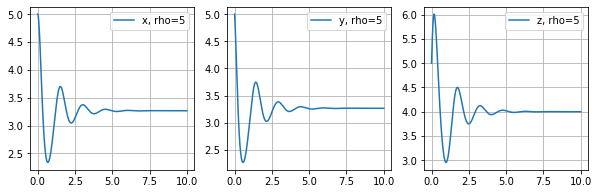

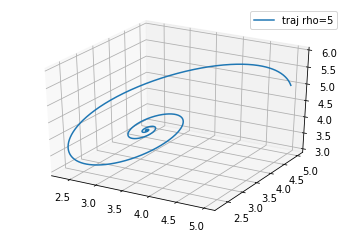

In [31]:
# Generate a trajectory
traj_rho5 = odeint(lorenz, y0, t, rho)

# Plot the single components
fig, ax = plt.subplots(1,3, figsize=(10,3))
for i, variable in enumerate(['x', 'y', 'z']):
  ax[i].plot(t, traj_rho5[:, i], label=f'{variable}, rho=5')
  ax[i].grid()
  ax[i].legend()
plt.show()

# Plot the 3d trajectory
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot(traj_rho5[:,0], traj_rho5[:,1], traj_rho5[:,2], label="traj rho=5")
ax.legend()
plt.show()

### (a) For this set of parameters, the solution converges to a stable fixed point. What happens when we change the initial conditions?

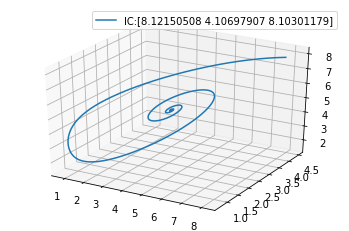

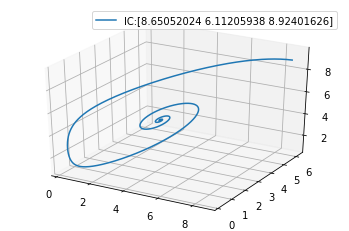

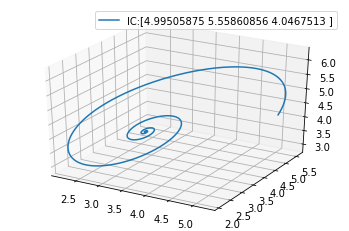

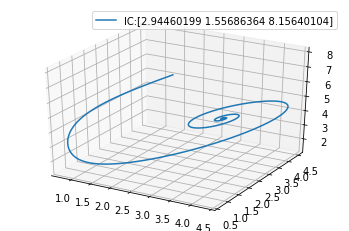

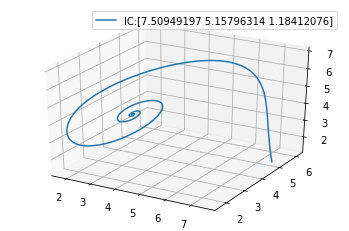

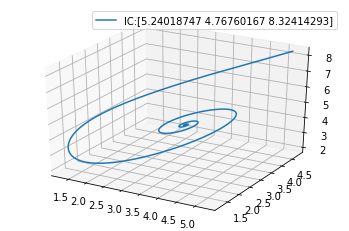

In [32]:
#fig, ax = plt.subplots(3,2, figsize=(10,6))
for i in range(6):
    y0_rand = 10*np_random.rand(3) # Try random initial conditions
    traj_rho5_rand = odeint(lorenz, y0_rand, t, rho)
    ax = plt.axes(projection='3d')
    ax.plot(traj_rho5_rand[:,0], traj_rho5_rand[:,1], traj_rho5_rand[:,2], label="IC:"+str(y0_rand))
    ax.legend()
    plt.show()
    

Even when we change the initial conditions, the solution still converges towards the same stable fixed point.

Now try to increase the value of $\rho$. You'll soon hit a value $\rho^*$ beyond which the solution becomes chaotic.

### (b) Give an estimate of $\rho^*$ 

Best automated estimate was ~17.802

### (c) What happens when we change the initial conditions for a system with $\rho>\rho^*$?

Even a small change in the initial conditions results in a large change to the trajectory.


In [289]:
# Your code here #
y0_new = np.array([5.0,5.0,5.0])

def est_rho_star_rec(rho_vec, iteration, num_parts, max_iters):
    
    # Check recursive break case
    if iteration == max_iters:
        return rho_vec
    
    else:
        # Iterate over all rho values
        for i, rho in enumerate(rho_vec):
            print("Trial Rho", rho)
            trial_traj = odeint(lorenz, y0_new, t, rho)

            # Check to see if this rho still converged to the same fixed point, could likely get better results
            # by looking at the max distance between any two points at this parameter value vs the previous one
            # since the jump to the butterfly would be much more obvious
            if onp.linalg.norm(trial_traj[-1,:]-trial_traj[-2,:])>=0.07:
                print("Did not converge at rho =", rho)
                new_rho_vec = onp.linspace(rho_vec[i-1],rho,num_parts)
                
                return est_rho_star_rec(new_rho_vec, iteration+1, num_parts, max_iters)

Trial Rho 5.0
Trial Rho 6.0
Trial Rho 7.0
Trial Rho 8.0
Trial Rho 9.0
Trial Rho 10.0
Trial Rho 11.0
Trial Rho 12.0
Trial Rho 13.0
Trial Rho 14.0
Trial Rho 15.0
Trial Rho 16.0
Trial Rho 17.0
Trial Rho 18.0
Did not converge at rho = 18.0
Trial Rho 17.0
Trial Rho 17.1
Trial Rho 17.2
Trial Rho 17.3
Trial Rho 17.4
Trial Rho 17.5
Trial Rho 17.6
Trial Rho 17.7
Trial Rho 17.8
Trial Rho 17.9
Did not converge at rho = 17.9
Trial Rho 17.8
Trial Rho 17.810000000000002
Did not converge at rho = 17.810000000000002
Trial Rho 17.8
Trial Rho 17.801000000000002
Trial Rho 17.802
Did not converge at rho = 17.802


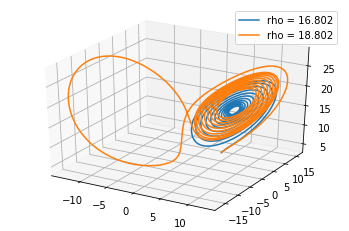

In [290]:
# Get an estimate for rho critical
est_rho_crit = est_rho_star_rec(onp.linspace(5,25,21), 1, 11, 5)[-1]    

# Plot the trajectory at IC (5,5,5) for rho critical
test_traj_1 = odeint(lorenz, y0_new, t, est_rho_crit-1)
test_traj_2 = odeint(lorenz, y0_new, t, est_rho_crit+1)
ax = plt.axes(projection='3d')
ax.plot(test_traj_1[:,0], test_traj_1[:,1], test_traj_1[:,2], label="rho = "+str(est_rho_crit-1))
ax.plot(test_traj_2[:,0], test_traj_2[:,1], test_traj_2[:,2], label="rho = "+str(est_rho_crit+1))
ax.legend()
plt.show()

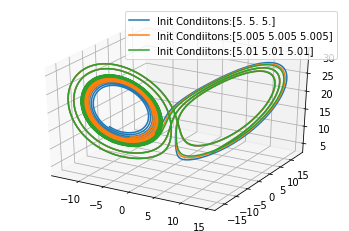

In [291]:
init_cond_offset = onp.linspace(0,0.01,3)
ax = plt.axes(projection='3d')

for nudge in init_cond_offset:
    y0_test = y0_new+nudge
    test_traj = odeint(lorenz, y0_test, t, 20)
    ax.plot(test_traj[:,0], test_traj[:,1], test_traj[:,2], label="Init Condiitons:"+str(y0_test))
    ax.legend()
plt.show()

## 2. Predict the parameters of the equations

We now give you two trajectories that have been generated for different parameters. In both cases we fix $\beta=8/3$.

### (a) Determine the value of $\rho$ and of the initial condition $(x_0,y_0,z_0)$ of the trajectory found in "Lorenz\_traj1.txt", where $\sigma = 10$.

[ Hint 1: for the initial guesses of $\rho$, remember what we learned with about the solution for different values of $\rho$ (above and below $\rho^*$) ]

[ Hint 2: for the initial guesses of $(x_0,y_0,z_0)$, look at your data! ]

Using the code below, got initial values estimate of (3, 6, 7) and a rho estimate of 6.9999995.

### (b) Determine the values of $\rho$ and $\sigma$ for the trajectory found in "Lorenz\_traj2.txt", where the initial condition is $(x_0,y_0,z_0) = (5,5,5)$ 

[ Hint: start with low values ]

Using the code below, got rho estimate of 6.9999995 and sigma estimate of 3.1450613.

In [340]:
### 2a ###

# Define the Lorenz system 
def lorenz_1(y_full, t, rho, sigma, beta):
    x,y,z = y_full
    dydt = np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z])
    return dydt

# Put in odeint form
lorenz_1_odeint = build_odeint(lorenz_1)

In [358]:
# Fix parameters
sigma_1, beta_1 = 10.0, 8/3

# Find true trajectory, initial conditions, and time
true_traj_1_data = onp.loadtxt('./Lorenz_traj1.txt')

true_traj_1 = true_traj_1_data[:,1:4]
t_1 = true_traj_1_data[:,0]
init_conds_1 = true_traj_1_data[0,1:4]

print("Initial conditions:", init_conds_1)

Initial conditions: [3. 6. 7.]


In [378]:
# Define the loss function
def loss_1(rho_1):
    return np.sum((lorenz_1_odeint(init_conds_1, t_1, rho_1, sigma_1, beta_1).reshape(-1)-true_traj_1.reshape(-1))**2)

In [399]:
# Get gradient with respect to rho
rho_1_grad = jit(grad(loss_1))

# Create an initial guess for rho
rho_est_1 = 2.0

# Pick a learning rate
lr_rho_1 = 0.001

# Perform the optimization
iter_count = 0
rho_1_list = [rho_est_1]
loss_1_list = [loss_1(rho_est_1)]
while True:
    rho_est_1 -= lr_rho_1 * rho_1_grad(rho_est_1)
    rho_1_list.append(rho_est_1)
    loss_1_list.append(loss_1(rho_est_1))
    iter_count += 1
    
    if onp.abs(rho_1_list[-2]-rho_1_list[-1]) < 10e-8 and onp.abs(loss_1_list[-2]-loss_1_list[-1]) < 10e-8:
        print("Converged on iteration", iter_count, "with rho estimate", rho_est_1)
        break
        
    elif iter_count > 1000:
        print("Failed to converge in 1000 iterations")
        break
        
    else: continue

Converged on iteration 49 with rho estimate 6.9999995


In [400]:
### 2b ###
# Define the Lorenz system 
def lorenz_2(y_full, t, rho, sigma, beta):
    x,y,z = y_full
    dydt = np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z])
    return dydt

# Put in odeint form
lorenz_2_odeint = build_odeint(lorenz_2)

In [401]:
# Fix parameters
beta_2 = 8.0/3.0

# Find true trajectory, initial conditions, and time
true_traj_2_data = onp.loadtxt('./Lorenz_traj2.txt')

true_traj_2 = true_traj_2_data[:,1:4]
t_2 = true_traj_2_data[:,0]
init_conds_2 = np.array([5.0, 5.0, 5.0])

In [402]:
# Define the loss function
def loss_2(rho_2, sigma_2):
    return np.sum((lorenz_2_odeint(init_conds, t_2, rho_2, sigma_2, beta_2).reshape(-1)-true_traj_2.reshape(-1))**2)

In [403]:
# Get gradient with respect to rho
rho_2_grad = jit(grad(loss_2,0))
sigma_2_grad = jit(grad(loss_2,1))

# Create an initial guess for rho
rho_est_2 = 2.0
sigma_est_2 = 2.0

# Pick a learning rate
lr_rho_2 = 0.001
lr_sigma_2 = 0.001

# Perform the optimization
iter_count = 0
rho_2_list = [rho_est_2]
sigma_2_list = [sigma_est_2]
loss_2_list = [loss_2(rho_est_2, sigma_est_2)]

while True:
    rho_est_2 -= lr_rho_2 * rho_2_grad(rho_est_2, sigma_est_2)
    sigma_est_2 -= lr_sigma_2 * sigma_2_grad(rho_est_2, sigma_est_2)
    rho_2_list.append(rho_est_2)
    sigma_2_list.append(sigma_est_2)
    loss_2_list.append(loss_2(rho_est_2, sigma_est_2))
    iter_count += 1
    
    if onp.abs(loss_2_list[-2]-loss_2_list[-1]) < 10e-8:
        print("Converged on iteration", iter_count, "with rho estimate", rho_est_1,
             "and sigma estimate", sigma_est_2)
        break
        
    elif iter_count > 1000:
        print("Failed to converge in 1000 iterations")
        break
        
    else: continue

Converged on iteration 24 with rho estimate 6.9999995 and sigma estimate 3.1450613
